In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix, \
    ConfusionMatrixDisplay, recall_score, precision_score, f1_score, fbeta_score, make_scorer

from xgboost import XGBClassifier

from collections import Counter
from tqdm import tqdm
import joblib

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

In [156]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.reshape(-1,)
y_test = pd.read_csv('y_test.csv').values.reshape(-1,)

In [ ]:
X_train.head()

In [157]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 161141, 0: 15352})
Counter({1: 69157, 0: 6483})


La variable ```TARGET``` est notre variable cible. Elle vaut *0* lorsque le client a des difficultés de paiement (il a payé en retard d'au moins X jours au moins une fois dans les Y premiers remboursements du prêt) et *1* sinon.

## Préparation des données

In [158]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(176493, 515)
(75640, 515)
(176493,)
(75640,)


## Modélisation

In [159]:
def RSE(y_test, predictions):
    """y_barre = y_test.mean()
    a1 = y_test - predictions
    a2 = sum(a1**2)
    print(a2.shape)
    b1 = y_test - y_barre
    b2 = sum(b1**2)
    print(b2.shape)
    RSE = a2 / b2
    print(RSE)"""
    y_barre = np.mean(y_test)
    RSE = sum((y_test - predictions)**2)/sum((y_test - y_barre)**2)
    return RSE


def plot_conf_matrix(y_true, y_pred):
    conf_matrix = (confusion_matrix(y_true, y_pred))

    fig = sns.heatmap(conf_matrix, annot=True, cmap='Blues')

    fig.set_title('Matrice de confusion')

    fig.set_xlabel('Valeurs Prédites')
    fig.set_ylabel('Valeurs Réelles')

    fig.xaxis.set_ticklabels(['Négatifs', 'Positifs'])
    fig.yaxis.set_ticklabels(['Négatifs', 'Positifs'])

    plt.show()


def Performances(model, X_test, y_test, predictions, seuil=0.5, cv=True):
    scores = []

    if cv:
        # Cross-validation score
        cv_score = model.best_score_
        print('Cross Validation score = {:.2f}'.format(cv_score))
        scores.append(cv_score)
    else:
        scores.append('')
    
    # Test score
    test_score = model.score(X_test, y_test)
    print('Test score = {:.2f}'.format(test_score))
    scores.append(test_score)

    # RMSE et MSE
    MSE = mean_squared_error(y_test, predictions, squared=True)
    print('RMSE = {:.2f}'.format(MSE**(1/2)))
    print('MSE = {:.2f}'.format(MSE))
    scores.append(MSE**(1/2))
    scores.append(MSE)

    # RSE
    RSE_ = RSE(y_test, predictions)
    print('RSE = {:.2f}'.format(RSE_))
    scores.append(RSE_)

    # ROC AUC score
    ROC_AUC = roc_auc_score(y_test, predictions)
    print('ROC_AUC = {:.2f}'.format(ROC_AUC))
    scores.append(ROC_AUC)

    # Courbe ROC
    [fpr, tpr, thr] = roc_curve(y_test, predictions)
    scores.append([fpr, tpr, thr])
    plt.plot(fpr, tpr, color='coral', lw=2, label='Classifier')
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('1 - Spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.show()

    y_pred = pd.Series(predictions).apply(lambda x: 1 if x >= seuil else 0)
    # Matrice de confusion
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='', cmap='Blues')

    # Rappel et précision
    Recall = recall_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    print('Recall = {:.2f}'.format(Recall))
    print('Precision = {:.2f}'.format(Precision))
    scores.append(Recall)
    scores.append(Precision)

    # F1-score
    F1 = f1_score(y_test, y_pred)
    print('Score F1 = {:.2f}'.format(F1))
    scores.append(F1)

    return scores

In [38]:
np.random.seed(5)
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)

### Dummy Classifier (Baseline)

In [39]:
dummy = DummyClassifier(strategy='most_frequent', random_state=0)

dummy.fit(X_train, y_train)
prediction_dummy = dummy.predict_proba(X_test)

Test score = 0.91
RMSE = 0.29
MSE = 0.09
RSE = 1.09
ROC_AUC = 0.50


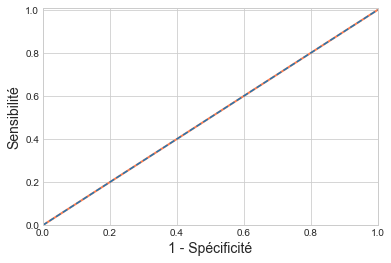

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


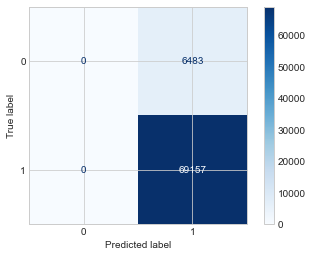

In [40]:
perf_dummy = Performances(dummy, X_test, y_test, prediction_dummy[:, 1], cv=False)

In [41]:
# Enregistrement du modèle
joblib.dump(dummy, 'Modèles/dummy.joblib')

# dummy_loaded = joblib.load('Modèles/dummy.joblib')

['Modèles/dummy.joblib']

## GridSearch

### Random Forest Classifier

In [42]:
param_RF = {'n_estimators': [100, 150, 200],
            'max_depth': [3, 5, None],
            'bootstrap': [True, False],
            'min_samples_leaf': [2, 4]}

RF = GridSearchCV(RandomForestClassifier(random_state=0),
                  param_grid=param_RF,
                  cv=cv_strat,
                  scoring='roc_auc',
                  verbose=3)

RF.fit(X_train, y_train)
# RF = joblib.load('Modèles/RF.joblib')

prediction_RF = RF.predict_proba(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.702 total time=  18.5s
[CV 2/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.715 total time=  17.1s
[CV 3/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.704 total time=  16.1s
[CV 4/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.706 total time=  15.7s
[CV 5/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.711 total time=  15.1s
[CV 1/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.700 total time=  25.9s
[CV 2/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.715 total time=  21.5s
[CV 3/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.703 total time=  21.3s
[CV 4/5] END bootstrap=True, max_depth=3, 

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200}
Cross Validation score = 0.74
Test score = 0.74
RMSE = 0.27
MSE = 0.07
RSE = 0.92
ROC_AUC = 0.74


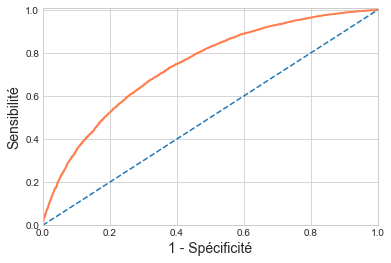

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


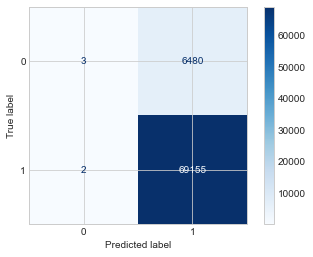

In [43]:
print('Meilleurs hyperparamètres : ' + str(RF.best_params_))

perf_RF = Performances(RF, X_test, y_test, prediction_RF[:, 1])

In [44]:
# Enregistrement du modèle
joblib.dump(RF, 'Modèles/RF.joblib')

['Modèles/RF.joblib']

### LightGBM

In [45]:
param_LGBM = {'max_depth': [5, 10, 15],
              'num_leaves': [20, 30],
              'n_estimators': [100, 300, 500]}

LGBM = GridSearchCV(LGBMClassifier(random_state=0),
                    param_grid=param_LGBM,
                    cv=cv_strat,
                    scoring='roc_auc',
                    verbose=3)

LGBM.fit(X_train, y_train)
# LGBM = joblib.load('Modèles/LGBM.joblib')

prediction_LGBM = LGBM.predict_proba(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.761 total time=   8.8s
[CV 2/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.769 total time=   8.2s
[CV 3/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.761 total time=   8.5s
[CV 4/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.767 total time=   6.8s
[CV 5/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.773 total time=   6.8s
[CV 1/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.761 total time=   7.0s
[CV 2/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.767 total time=   7.3s
[CV 3/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.760 total time=   6.9s
[CV 4/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.768 total time=   8.0s
[CV 5/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.773 total time=   6.8s
[CV 1/5] END max_depth=5, n_e

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 300, 'num_leaves': 20}
Cross Validation score = 0.77
Test score = 0.78
RMSE = 0.26
MSE = 0.07
RSE = 0.89
ROC_AUC = 0.78


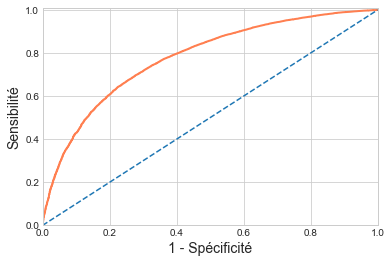

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


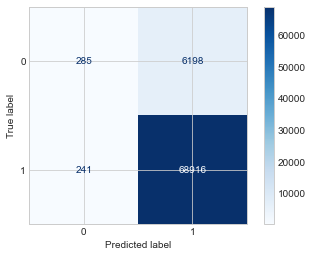

In [46]:
print('Meilleurs hyperparamètres : ' + str(LGBM.best_params_))

perf_LGBM = Performances(LGBM, X_test, y_test, prediction_LGBM[:, 1])

In [47]:
# Enregistrement du modèle
joblib.dump(LGBM, 'Modèles/LGBM.joblib')

['Modèles/LGBM.joblib']

### XGBoost

In [48]:
param_XGB = {'max_depth': [5, 10, 15],
             'learning_rate': [0.1, 0.15, 0.3],
             'n_estimators': [100, 300, 500]}

XGB = GridSearchCV(XGBClassifier(random_state=0),
                   param_grid=param_XGB,
                   cv=cv_strat,
                   scoring='roc_auc',
                   verbose=3)

XGB.fit(X_train, y_train)
# XGB = joblib.load('Modèles/XGB.joblib')

prediction_XGB = XGB.predict_proba(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.763 total time= 1.3min
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.769 total time= 1.4min
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.762 total time= 1.4min
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.768 total time= 1.4min
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.774 total time= 1.4min
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.769 total time= 3.9min
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.772 total time= 3.9min
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.766 total time= 3.9min
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.772 total time= 3.9min
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.780 total t

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Cross Validation score = 0.77
Test score = 0.78
RMSE = 0.26
MSE = 0.07
RSE = 0.89
ROC_AUC = 0.78


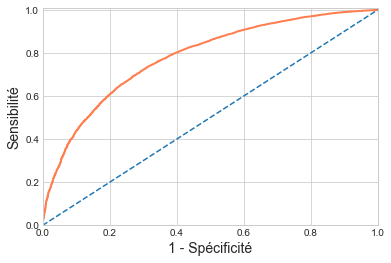

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


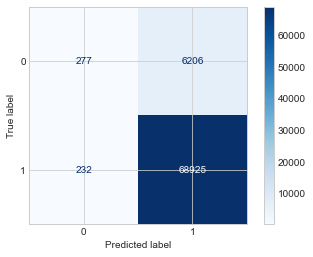

In [49]:
print('Meilleurs hyperparamètres : ' + str(XGB.best_params_))

perf_XGB = Performances(XGB, X_test, y_test, prediction_XGB[:, 1])

In [50]:
# Enregistrement du modèle
joblib.dump(XGB, 'Modèles/XGB.joblib')

['Modèles/XGB.joblib']

### Logistic Regression

In [51]:
param_Logistic = {'C': np.logspace(-4, 4, 20),
                  'penalty': ['none', 'l2']}

Logistic = GridSearchCV(LogisticRegression(random_state=0),
                        param_grid=param_Logistic,
                        cv=cv_strat,
                        scoring='roc_auc',
                        verbose=3)

Logistic.fit(X_train, y_train)
# Logistic = joblib.load('Modèles/Logistic.joblib')

prediction_Logistic = Logistic.predict_proba(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ............C=0.0001, penalty=none;, score=0.587 total time=   7.1s
[CV 2/5] END ............C=0.0001, penalty=none;, score=0.592 total time=  11.0s
[CV 3/5] END ............C=0.0001, penalty=none;, score=0.582 total time=   9.0s
[CV 4/5] END ............C=0.0001, penalty=none;, score=0.593 total time=   8.6s
[CV 5/5] END ............C=0.0001, penalty=none;, score=0.592 total time=   7.7s
[CV 1/5] END ..............C=0.0001, penalty=l2;, score=0.587 total time=   5.8s
[CV 2/5] END ..............C=0.0001, penalty=l2;, score=0.591 total time=   6.4s
[CV 3/5] END ..............C=0.0001, penalty=l2;, score=0.582 total time=   7.3s
[CV 4/5] END ..............C=0.0001, penalty=l2;, score=0.593 total time=  12.6s
[CV 5/5] END ..............C=0.0001, penalty=l2;, score=0.592 total time=   6.9s
[CV 1/5] END C=0.00026366508987303583, penalty=none;, score=0.587 total time=   5.7s
[CV 2/5] END C=0.00026366508987303583, pena

Meilleurs hyperparamètres : {'C': 0.0006951927961775605, 'penalty': 'l2'}
Cross Validation score = 0.59
Test score = 0.60
RMSE = 0.28
MSE = 0.08
RSE = 1.00
ROC_AUC = 0.60


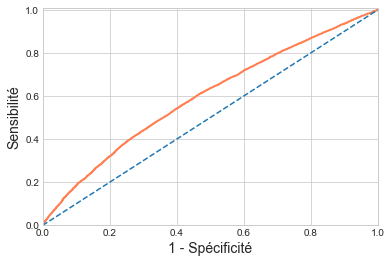

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


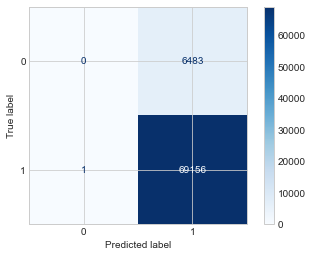

In [52]:
print('Meilleurs hyperparamètres : ' + str(Logistic.best_params_))

perf_Logistic = Performances(Logistic, X_test, y_test, prediction_Logistic[:, 1])

In [53]:
# Enregistrement du modèle
joblib.dump(Logistic, 'Modèles/Logistic.joblib')

['Modèles/Logistic.joblib']

### Comparaison des performances

In [54]:
def displayPerformances(listePerf):
    listeCV = [perf[0] for perf in listePerf]
    listeTest = [perf[1] for perf in listePerf]
    listeRMSE = [perf[2] for perf in listePerf]
    listeMSE = [perf[3] for perf in listePerf]
    listeRSE = [perf[4] for perf in listePerf]
    listeAUC = [perf[5] for perf in listePerf]
    listeRecall = [perf[7] for perf in listePerf]
    listePrecision = [perf[8] for perf in listePerf]
    listeF1 = [perf[9] for perf in listePerf]
    listeModeles = ['Dummy Classifier', 'Random Forest', 'LGBM',
                    'XGBoost', 'Logistic Regression']
    score = pd.DataFrame()
    score['Modèle'] = listeModeles
    score['Score de Cross-Validation'] = listeCV
    score['Score de test'] = listeTest
    score['RMSE'] = listeRMSE
    score['MSE'] = listeMSE
    score['RSE'] = listeRSE
    score['AUC'] = listeAUC
    score['Rappel'] = listeRecall
    score['Précision'] = listePrecision
    score['F1'] = listeF1

    fig = plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Modèle', y='AUC', data=score)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title('Score AUC des différents modèles testés',
            fontsize=20)
    plt.xlabel('Les différents modèles testés', fontsize=20)
    plt.ylabel('Score AUC', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    fig = plt.figure(figsize=(12, 8))
    for perf in listePerf:
        [fpr, tpr, thr] = perf[6]
        plt.plot(fpr, tpr, lw=2)
    plt.legend(listeModeles)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.show()

    new_score = score.T
    new_score.columns = new_score.iloc[0, :]
    new_score.drop(new_score.loc[new_score['Dummy Classifier'] == 'Dummy Classifier'].index, inplace=True)
    return new_score

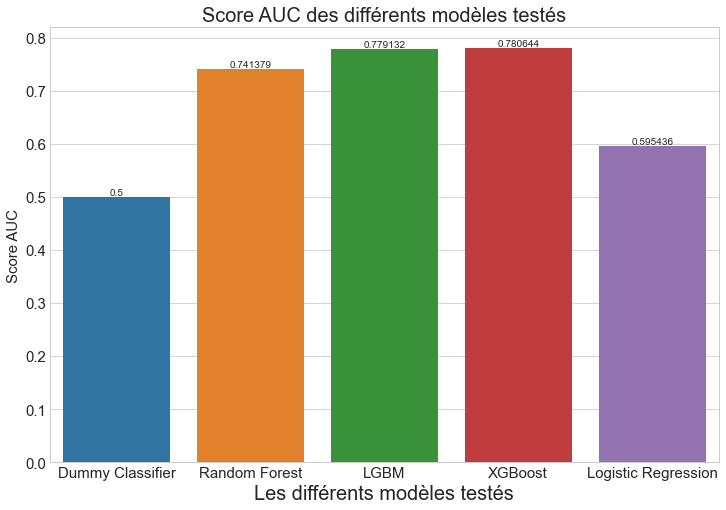

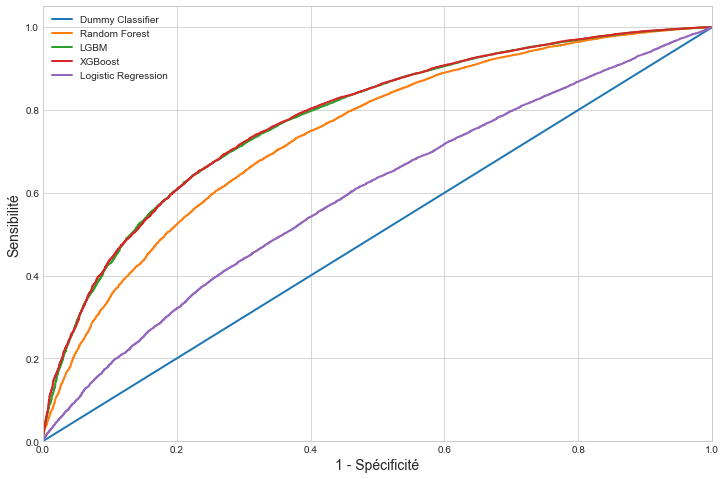

Modèle,Dummy Classifier,Random Forest,LGBM,XGBoost,Logistic Regression
Score de Cross-Validation,,0.736202,0.770305,0.771804,0.589448
Score de test,0.914291,0.741379,0.779132,0.780644,0.595436
RMSE,0.29276,0.269136,0.264621,0.264362,0.280214
MSE,0.085709,0.072434,0.070025,0.069887,0.07852
RSE,1.093743,0.924348,0.893596,0.891841,1.002005
AUC,0.5,0.741379,0.779132,0.780644,0.595436
Rappel,1.0,0.999971,0.996515,0.996645,0.999986
Précision,0.914291,0.914325,0.917485,0.917398,0.91429
F1,0.955227,0.955232,0.955369,0.955381,0.95522


In [55]:
listePerf = [perf_dummy, perf_RF, perf_LGBM, perf_XGB, perf_Logistic]
df_score = displayPerformances(listePerf)
df_score.head(df_score.shape[0])

## GridSearch + SMOTE

In [56]:
Counter(y_train)

Counter({0: 15352, 1: 161141})

In [57]:
Smote = SMOTE(sampling_strategy=0.5)
X_SMOTE, y_SMOTE = Smote.fit_resample(X_train, y_train)

In [58]:
Counter(y_SMOTE)

Counter({0: 80570, 1: 161141})

### Random Forest Classifier

In [59]:
RF_SMOTE = GridSearchCV(RandomForestClassifier(random_state=0),
                        param_grid=param_RF,
                        cv=cv_strat,
                        scoring='roc_auc',
                        verbose=3)

RF_SMOTE.fit(X_SMOTE, y_SMOTE)
# RF_SMOTE = joblib.load('Modèles/RF_SMOTE.joblib')

prediction_RF_SMOTE = RF_SMOTE.predict_proba(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.902 total time=  35.3s
[CV 2/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.899 total time=  35.0s
[CV 3/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.903 total time=  34.5s
[CV 4/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.901 total time=  35.0s
[CV 5/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.904 total time=  34.7s
[CV 1/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.904 total time=  50.6s
[CV 2/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.899 total time=  50.5s
[CV 3/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.902 total time=  51.2s
[CV 4/5] END bootstrap=True, max_depth=3, 

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Cross Validation score = 0.96
Test score = 0.72
RMSE = 0.27
MSE = 0.07
RSE = 0.95
ROC_AUC = 0.72


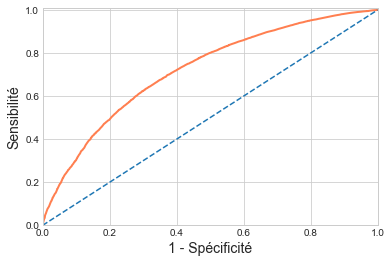

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


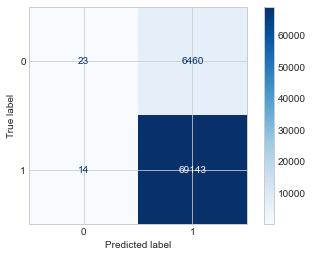

In [60]:
print('Meilleurs hyperparamètres : ' + str(RF_SMOTE.best_params_))

perf_RF_SMOTE = Performances(RF_SMOTE, X_test, y_test, prediction_RF_SMOTE[:, 1])

In [61]:
# Enregistrement du modèle
joblib.dump(RF_SMOTE, 'Modèles/RF_SMOTE.joblib')

['Modèles/RF_SMOTE.joblib']

### LightGBM

In [62]:
LGBM_SMOTE = GridSearchCV(LGBMClassifier(random_state=0),
                          param_grid=param_LGBM,
                          cv=cv_strat,
                          scoring='roc_auc',
                          verbose=3)

LGBM_SMOTE.fit(X_SMOTE, y_SMOTE)
# LGBM_SMOTE = joblib.load('Modèles/LGBM_SMOTE.joblib')

prediction_LGBM_SMOTE = LGBM_SMOTE.predict_proba(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.952 total time=  25.8s
[CV 2/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.953 total time=  23.2s
[CV 3/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.953 total time=  23.1s
[CV 4/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.953 total time=  22.9s
[CV 5/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.954 total time=  22.3s
[CV 1/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.952 total time=  23.2s
[CV 2/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.953 total time=  22.8s
[CV 3/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.953 total time=  22.7s
[CV 4/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.953 total time=  23.4s
[CV 5/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.954 total time=  22.8s
[CV 1/5] END max_depth=5, n_e

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 500, 'num_leaves': 30}
Cross Validation score = 0.96
Test score = 0.78
RMSE = 0.27
MSE = 0.07
RSE = 0.90
ROC_AUC = 0.78


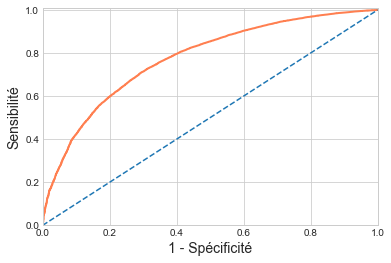

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


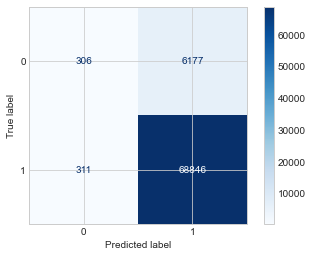

In [63]:
print('Meilleurs hyperparamètres : ' + str(LGBM_SMOTE.best_params_))

perf_LGBM_SMOTE = Performances(LGBM_SMOTE, X_test, y_test, prediction_LGBM_SMOTE[:, 1])

In [64]:
# Enregistrement du modèle
joblib.dump(LGBM_SMOTE, 'Modèles/LGBM_SMOTE.joblib')

['Modèles/LGBM_SMOTE.joblib']

### XGBoost

In [67]:
XGB_SMOTE = GridSearchCV(XGBClassifier(random_state=0),
                         param_grid=param_XGB,
                         cv=cv_strat,
                         scoring='roc_auc',
                         verbose=3)

XGB_SMOTE.fit(X_SMOTE, y_SMOTE)
# XGB_SMOTE = joblib.load('Modèles/XGB_SMOTE.joblib')

prediction_XGB_SMOTE = XGB_SMOTE.predict_proba(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.952 total time= 3.6min
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.953 total time= 2.9min
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.953 total time= 3.8min
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.953 total time= 3.5min
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.954 total time= 4.0min
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.955 total time= 9.4min
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.956 total time=13.3min
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.956 total time=11.8min
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.956 total time=10.4min
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.957 total t

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
Cross Validation score = 0.96
Test score = 0.58
RMSE = 0.28
MSE = 0.08
RSE = 0.99
ROC_AUC = 0.76


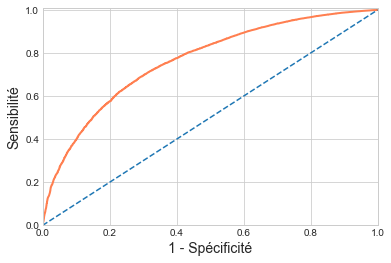

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


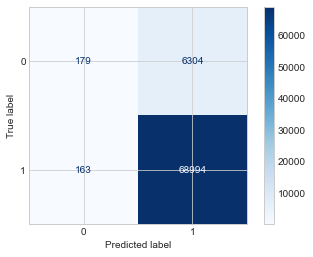

In [68]:
print('Meilleurs hyperparamètres : ' + str(XGB_SMOTE.best_params_))

perf_XGB_SMOTE = Performances(XGB_SMOTE, X_test, y_test, prediction_XGB_SMOTE[:, 1])

In [69]:
# Enregistrement du modèle
joblib.dump(XGB_SMOTE, 'Modèles/XGB_SMOTE.joblib')

['Modèles/XGB_SMOTE.joblib']

### Logistic Regression

In [ ]:
Logistic_SMOTE = GridSearchCV(LogisticRegression(random_state=0),
                              param_grid=param_Logistic,
                              cv=cv_strat,
                              scoring='roc_auc',
                              verbose=3)

Logistic_SMOTE.fit(X_SMOTE, y_SMOTE)
# Logistic_SMOTE = joblib.load('Modèles/Logistic_SMOTE.joblib')

prediction_Logistic_SMOTE = Logistic_SMOTE.predict_proba(X_test)

Meilleurs hyperparamètres : {'C': 0.0001, 'penalty': 'l2'}
Cross Validation score = 0.59
Test score = 0.60
RMSE = 0.37
MSE = 0.14
RSE = 1.74
ROC_AUC = 0.60


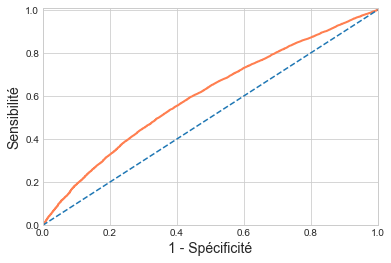

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


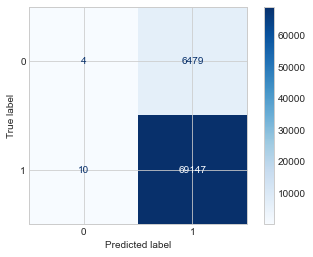

In [160]:
print('Meilleurs hyperparamètres : ' + str(Logistic_SMOTE.best_params_))

perf_Logistic_SMOTE = Performances(Logistic_SMOTE, X_test, y_test, prediction_Logistic_SMOTE[:, 1])

In [161]:
# Enregistrement du modèle
joblib.dump(Logistic_SMOTE, 'Modèles/Logistic_SMOTE.joblib')

['Modèles/Logistic_SMOTE.joblib']

### Comparaison des performances

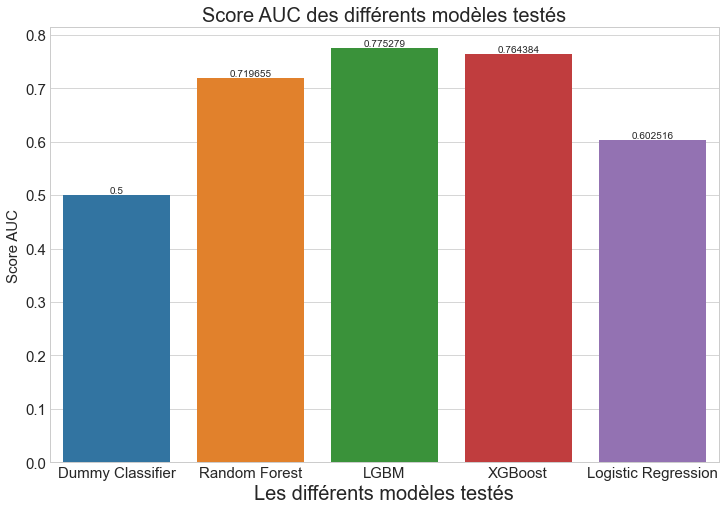

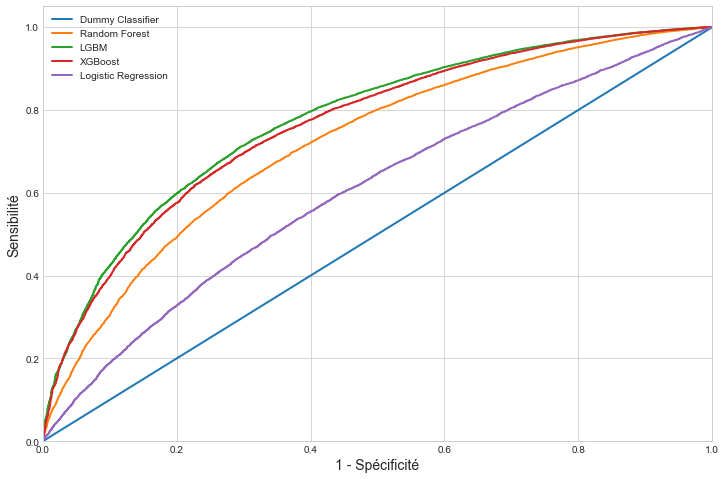

Modèle,Dummy Classifier,Random Forest,LGBM,XGBoost,Logistic Regression
Score de Cross-Validation,,0.956523,0.956005,0.958966,0.588119
Score de test,0.914291,0.719655,0.775279,0.579106,0.602516
RMSE,0.29276,0.273451,0.265582,0.278544,0.369219
MSE,0.085709,0.074775,0.070534,0.077587,0.136323
RSE,1.093743,0.954222,0.900096,0.990097,1.739638
AUC,0.5,0.719655,0.775279,0.764384,0.602516
Rappel,1.0,0.999798,0.995503,0.997643,0.999855
Précision,0.914291,0.914554,0.917665,0.916279,0.914328
F1,0.955227,0.955278,0.955001,0.955232,0.955181


In [162]:
listePerf_SMOTE = [perf_dummy, perf_RF_SMOTE, perf_LGBM_SMOTE, perf_XGB_SMOTE, perf_Logistic_SMOTE]
df_score_SMOTE = displayPerformances(listePerf_SMOTE)
df_score_SMOTE.head(df_score_SMOTE.shape[0])

## GridSearch + SMOTE SE

In [163]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_SMOTE_SE, y_SMOTE_SE = pipeline.fit_resample(X_train, y_train)

### Random Forest Classifier

In [164]:
RF_SMOTE_SE = GridSearchCV(RandomForestClassifier(random_state=0),
                           param_grid=param_RF,
                           cv=cv_strat,
                           scoring='roc_auc',
                           verbose=3)

RF_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
# RF_SMOTE_SE = joblib.load('Modèles/RF_SMOTE_SE.joblib')

prediction_RF_SMOTE_SE = RF_SMOTE_SE.predict_proba(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.705 total time=   4.3s
[CV 2/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.708 total time=   4.2s
[CV 3/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.713 total time=   4.3s
[CV 4/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.710 total time=   4.6s
[CV 5/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=100;, score=0.702 total time=   4.5s
[CV 1/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.703 total time=   6.8s
[CV 2/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.707 total time=   6.4s
[CV 3/5] END bootstrap=True, max_depth=3, min_samples_leaf=2, n_estimators=150;, score=0.711 total time=   6.3s
[CV 4/5] END bootstrap=True, max_depth=3, 

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Cross Validation score = 0.76
Test score = 0.75
RMSE = 0.35
MSE = 0.12
RSE = 1.56
ROC_AUC = 0.75


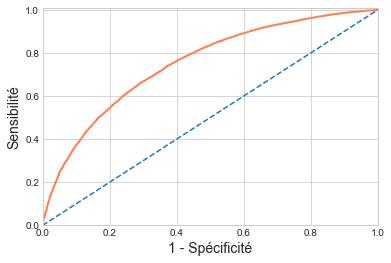

Recall = 0.93
Precision = 0.93
Score F1 = 0.93


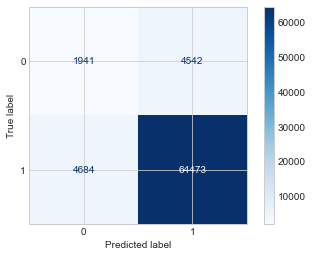

In [165]:
print('Meilleurs hyperparamètres : ' + str(RF_SMOTE_SE.best_params_))

perf_RF_SMOTE_SE = Performances(RF_SMOTE_SE, X_test, y_test, prediction_RF_SMOTE_SE[:, 1])

In [166]:
# Enregistrement du modèle
joblib.dump(RF_SMOTE_SE, 'Modèles/RF_SMOTE_SE.joblib')

['Modèles/RF_SMOTE_SE.joblib']

### LightGBM

In [167]:
LGBM_SMOTE_SE = GridSearchCV(LGBMClassifier(random_state=0),
                             param_grid=param_LGBM,
                             cv=cv_strat,
                             scoring='roc_auc',
                             verbose=3)

LGBM_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
# LGBM_SMOTE_SE = joblib.load('Modèles/LGBM_SMOTE_SE.joblib')

prediction_LGBM_SMOTE_SE = LGBM_SMOTE_SE.predict_proba(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.770 total time=   3.0s
[CV 2/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.773 total time=   2.8s
[CV 3/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.782 total time=   3.0s
[CV 4/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.777 total time=   2.6s
[CV 5/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.773 total time=   2.8s
[CV 1/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.769 total time=   2.7s
[CV 2/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.775 total time=   2.9s
[CV 3/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.781 total time=   2.9s
[CV 4/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.775 total time=   3.0s
[CV 5/5] END max_depth=5, n_estimators=100, num_leaves=30;, score=0.772 total time=   3.1s
[CV 1/5] END max_depth=5, n_e

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 300, 'num_leaves': 20}
Cross Validation score = 0.78
Test score = 0.78
RMSE = 0.34
MSE = 0.12
RSE = 1.50
ROC_AUC = 0.78


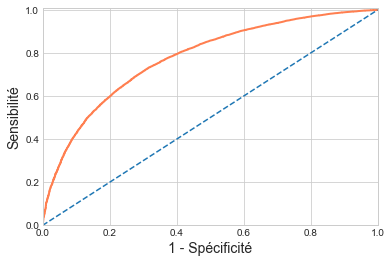

Recall = 0.88
Precision = 0.94
Score F1 = 0.91


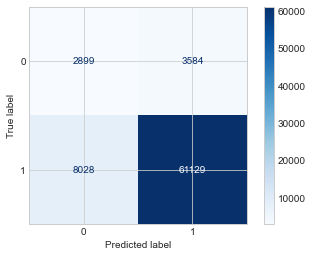

In [168]:
print('Meilleurs hyperparamètres : ' + str(LGBM_SMOTE_SE.best_params_))

perf_LGBM_SMOTE_SE = Performances(LGBM_SMOTE_SE, X_test, y_test, prediction_LGBM_SMOTE_SE[:, 1])

In [169]:
# Enregistrement du modèle
joblib.dump(LGBM_SMOTE_SE, 'Modèles/LGBM_SMOTE_SE.joblib')

['Modèles/LGBM_SMOTE_SE.joblib']

### XGBoost

In [170]:
XGB_SMOTE_SE = GridSearchCV(XGBClassifier(random_state=0),
                            param_grid=param_XGB,
                            cv=cv_strat,
                            scoring='roc_auc',
                            verbose=3)

XGB_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
# XGB_SMOTE_SE = joblib.load('Modèles/XGB_SMOTE_SE.joblib')

prediction_XGB_SMOTE_SE = XGB_SMOTE_SE.predict_proba(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.769 total time=  29.6s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.774 total time=  32.9s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.781 total time=  34.2s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.777 total time=  32.2s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.772 total time=  30.2s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.774 total time= 1.7min
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.781 total time= 1.7min
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.786 total time= 1.6min
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.779 total time= 1.6min
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.777 total t

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Cross Validation score = 0.78
Test score = 0.78
RMSE = 0.34
MSE = 0.12
RSE = 1.50
ROC_AUC = 0.78


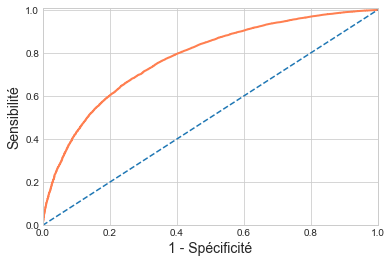

Recall = 0.88
Precision = 0.94
Score F1 = 0.91


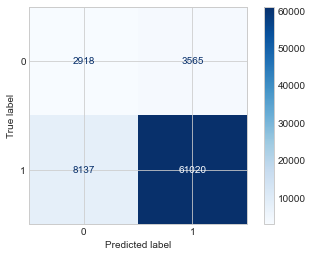

In [171]:
print('Meilleurs hyperparamètres : ' + str(XGB_SMOTE_SE.best_params_))

perf_XGB_SMOTE_SE = Performances(XGB_SMOTE_SE, X_test, y_test, prediction_XGB_SMOTE_SE[:, 1])

In [172]:
# Enregistrement du modèle
joblib.dump(XGB_SMOTE_SE, 'Modèles/XGB_SMOTE_SE.joblib')

['Modèles/XGB_SMOTE_SE.joblib']

### Logistic Regression

In [173]:
Logistic_SMOTE_SE = GridSearchCV(LogisticRegression(random_state=0),
                                 param_grid=param_Logistic,
                                 cv=cv_strat,
                                 scoring='roc_auc',
                                 verbose=3)

Logistic_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
# Logistic_SMOTE_SE = joblib.load('Modèles/Logistic_SMOTE_SE.joblib')

prediction_Logistic_SMOTE_SE = Logistic_SMOTE_SE.predict_proba(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ............C=0.0001, penalty=none;, score=0.608 total time=   2.5s
[CV 2/5] END ............C=0.0001, penalty=none;, score=0.598 total time=   1.8s
[CV 3/5] END ............C=0.0001, penalty=none;, score=0.605 total time=   1.9s
[CV 4/5] END ............C=0.0001, penalty=none;, score=0.588 total time=   2.1s
[CV 5/5] END ............C=0.0001, penalty=none;, score=0.595 total time=   1.8s
[CV 1/5] END ..............C=0.0001, penalty=l2;, score=0.608 total time=   2.0s
[CV 2/5] END ..............C=0.0001, penalty=l2;, score=0.598 total time=   1.8s
[CV 3/5] END ..............C=0.0001, penalty=l2;, score=0.605 total time=   1.7s
[CV 4/5] END ..............C=0.0001, penalty=l2;, score=0.588 total time=   2.0s
[CV 5/5] END ..............C=0.0001, penalty=l2;, score=0.595 total time=   1.9s
[CV 1/5] END C=0.00026366508987303583, penalty=none;, score=0.608 total time=   2.1s
[CV 2/5] END C=0.00026366508987303583, pena

Meilleurs hyperparamètres : {'C': 0.004832930238571752, 'penalty': 'l2'}
Cross Validation score = 0.60
Test score = 0.60
RMSE = 0.37
MSE = 0.14
RSE = 1.74
ROC_AUC = 0.60


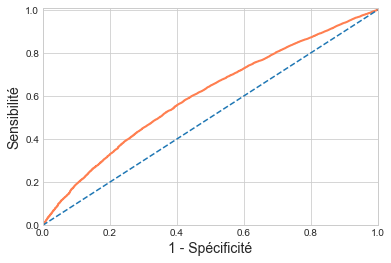

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


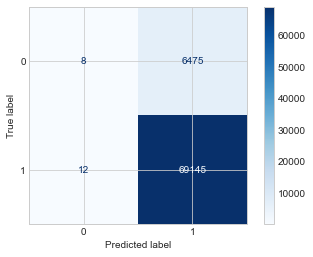

In [174]:
print('Meilleurs hyperparamètres : ' + str(Logistic_SMOTE_SE.best_params_))

perf_Logistic_SMOTE_SE = Performances(Logistic_SMOTE_SE, X_test, y_test, prediction_Logistic_SMOTE_SE[:, 1])

In [175]:
# Enregistrement du modèle
joblib.dump(Logistic_SMOTE_SE, 'Modèles/Logistic_SMOTE_SE.joblib')

['Modèles/Logistic_SMOTE_SE.joblib']

### Comparaison des performances

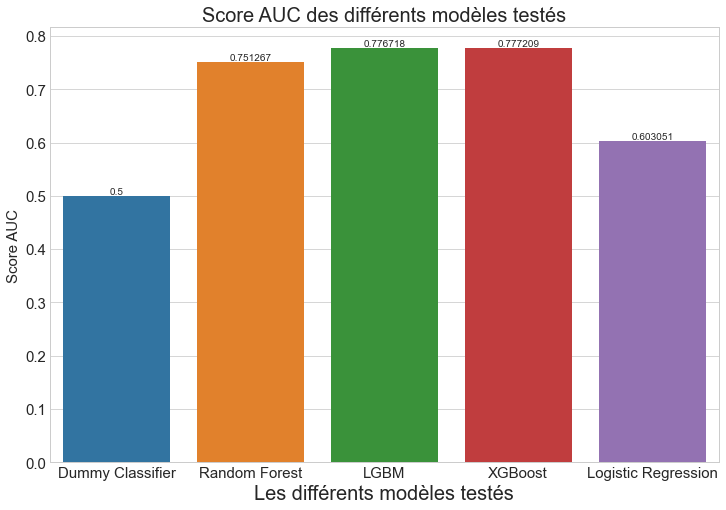

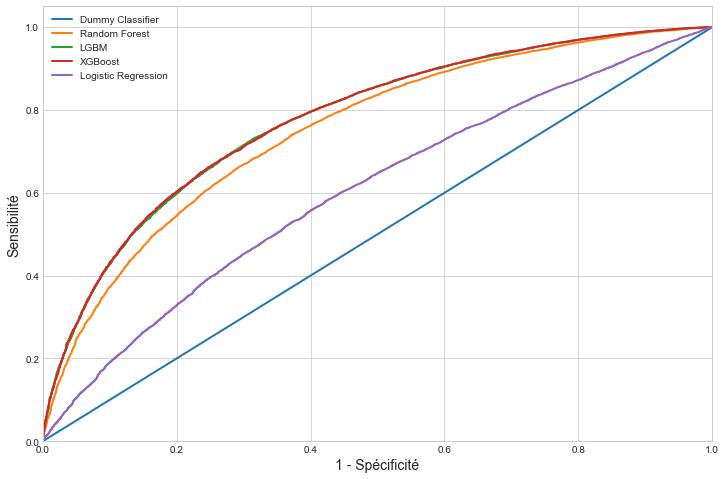

Modèle,Dummy Classifier,Random Forest,LGBM,XGBoost,Logistic Regression
Score de Cross-Validation,,0.75697,0.778263,0.77948,0.598582
Score de test,0.914291,0.751267,0.776718,0.777209,0.603051
RMSE,0.29276,0.349251,0.342657,0.343004,0.368965
MSE,0.085709,0.121976,0.117414,0.117652,0.136135
RSE,1.093743,1.556559,1.498338,1.501374,1.737242
AUC,0.5,0.751267,0.776718,0.777209,0.603051
Rappel,1.0,0.93227,0.883916,0.88234,0.999826
Précision,0.914291,0.934188,0.944617,0.944801,0.914375
F1,0.955227,0.933228,0.913259,0.912503,0.955193


In [176]:
listePerf_SMOTE_SE = [perf_dummy, perf_RF_SMOTE_SE, perf_LGBM_SMOTE_SE, perf_XGB_SMOTE_SE, perf_Logistic_SMOTE_SE]
df_score_SMOTE_SE = displayPerformances(listePerf_SMOTE_SE)
df_score_SMOTE_SE.head(df_score_SMOTE_SE.shape[0])

## Comparaison des performances

In [177]:
def CreateDfScore(df, strategie, dummy=False):
    df_score = df.copy()
    if not dummy:
        df_score.drop('Dummy Classifier', axis=1, inplace=True)

    new_df_score = pd.DataFrame()
    for col in df_score.columns:
        new_df = pd.DataFrame()
        new_df['Score'] = df_score[col]
        new_df['Modèle'] = [col]*new_df.shape[0]
        new_df_score = pd.concat([new_df_score, new_df])

    new_df_score['Stratégie'] = [strategie]*new_df_score.shape[0]
    return new_df_score

df_dummy = CreateDfScore(df_score[['Dummy Classifier']], 'Baseline', dummy=True)
df_grid = CreateDfScore(df_score, 'GridSearch')
df_SMOTE = CreateDfScore(df_score_SMOTE, 'GridSearch + SMOTE')
df_SMOTE_SE = CreateDfScore(df_score_SMOTE_SE, 'GridSearch + SMOTE SE')

df2 = pd.concat([df_dummy, df_grid, df_SMOTE, df_SMOTE_SE], axis=0)
df2.head()
pivoted = df2.pivot(columns=['Stratégie', 'Modèle'])
pivoted = pivoted.reindex(df_score.index)
pivoted = pivoted.droplevel(0, axis=1)
s = pivoted.style.format(na_rep='')
s

En se basant sur le score *AUC*, le meilleur modèle est *XGBoost* avec une grille de recherche sans échantillonnage.
Cependant, le score du modèle *LGBM* sans échantillonnage en est très proche et le temps d'apprentissage est bien plus faible et le modèle plus simple. Nous choisissons donc *LGBM* comme étant notre meilleur modèle.

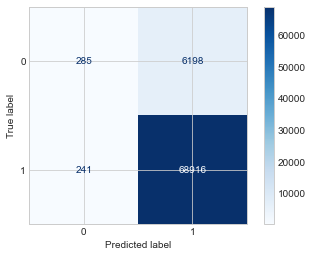

In [179]:
best_model = joblib.load('Modèles/LGBM.joblib').best_estimator_
y_pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='', cmap='Blues')

## Fonction de coût métier

In [180]:
def cout_metier(y_true, y_pred, poids_fp=10, poids_fn=1):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    return fp*poids_fp + fn*poids_fn

### A l'aide de fbeta_score
Dans notre cas, la valeur *0* est attribuée aux *bons* clients et la valeur *1* aux *mauvais* clients.
Si notre modèle catégorise un *bon* client comme un *mauvais* client (prédiction *1* pour vraie valeur *0*), ce n'est pas très grave. En revanche, il ne faut surtout pas catégoriser un *mauvais* client comme un *bon* client (FP = 0).
Precision = TP / (TP + FP)
Rappel = TP / (TP + FN)
Nous voulons donc une **précision le plus proche possible de 1**. Nous cherchons donc un Beta qui se rapproche de 0.

In [186]:
cout_min = 11*y_test.shape[0]
best_beta = 0

for beta_ in [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]:
    print(beta_)
    scorer = make_scorer(fbeta_score, beta=beta_)
    model = GridSearchCV(LGBMClassifier(random_state=0),
                         param_grid=param_LGBM,
                         cv=cv_strat,
                         scoring=scorer,
                         verbose=3)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cout = cout_metier(y_test, y_pred)
    print('cout =', cout, '; cout_min =', cout_min)
    if cout < cout_min:
        cout_min = cout
        best_beta = beta_
        joblib.dump(model, 'Modèles/best_model_beta.joblib')

0.5
Fitting 5 folds for each of 18 candidates, totalling 90 fits
cout = 61896 ; cout_min = 832040
0.2
Fitting 5 folds for each of 18 candidates, totalling 90 fits
cout = 61896 ; cout_min = 61896
0.1
Fitting 5 folds for each of 18 candidates, totalling 90 fits
cout = 61896 ; cout_min = 61896
0.05
Fitting 5 folds for each of 18 candidates, totalling 90 fits
cout = 61896 ; cout_min = 61896
0.02
Fitting 5 folds for each of 18 candidates, totalling 90 fits
cout = 61896 ; cout_min = 61896
0.01
Fitting 5 folds for each of 18 candidates, totalling 90 fits
cout = 61896 ; cout_min = 61896


In [203]:
print('Le coût métier atteint son minimum (', cout_min, ') pour beta =', best_beta)

Le coût métier atteint son minimum ( 61896 ) pour beta = 0.5


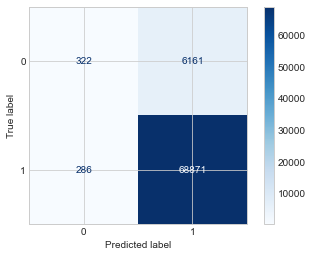

In [204]:
best_model_beta = joblib.load('Modèles/best_model_beta.joblib')
y_pred = best_model_beta.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='', cmap='Blues')
plt.show()

### En choisissant un seuil
Nous allons tester notre meilleur modèle pour différentes valeurs de seuil afin de sélectionner le meilleur.

100%|██████████| 100/100 [00:03<00:00, 31.02it/s]


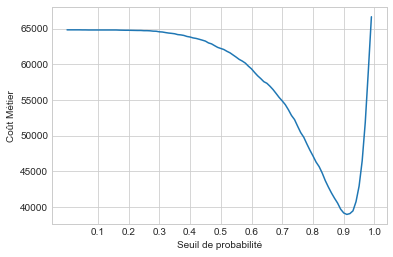

Le coût métier atteint son minimum ( 38961 ) pour un seuil de probabilité de 0.91


In [189]:
best_model = joblib.load('Modèles/LGBM.joblib')
cost_function = []
threshold_x = []
predictions = best_model.predict_proba(X_test)
for t in tqdm(range(100)):
    thresh = t/100
    y_pred = pd.Series(predictions[:, 1]).apply(lambda x: 1 if x >= thresh else 0)
    c = cout_metier(y_test, y_pred, poids_fp=10, poids_fn=1)
    cost_function.append(c)
    threshold_x.append(thresh)

plt.plot(threshold_x, cost_function)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Coût Métier")
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()

min_ = np.argmin(cost_function)
print('Le coût métier atteint son minimum (', cost_function[min_], ') pour un seuil de probabilité de', threshold_x[min_])

Affichons la matrice de confusion pour le seuil de probabilité optimal.

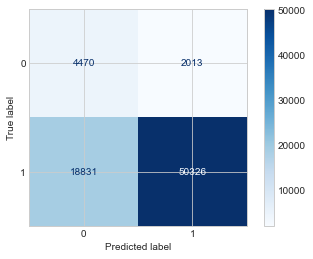

In [190]:
y_pred = pd.Series(predictions[:, 1]).apply(lambda x: 1 if x >= threshold_x[min_] else 0)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='', cmap='Blues')
plt.show()

## Analyse du meilleur modèle

In [191]:
import shap

In [192]:
if cost_function[min_] <= cout_min:
    model = joblib.load('Modèles/LGBM.joblib')
else:
    model = joblib.load('Modèles/best_model_beta.joblib')
best_model = model.best_estimator_

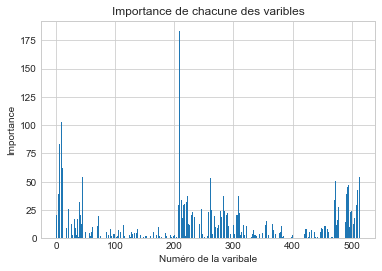

In [193]:
feature_importance_df_ = best_model.feature_importances_

plt.bar([x for x in range(len(feature_importance_df_))], feature_importance_df_)
plt.title('Importance de chacune des varibles')
plt.xlabel('Numéro de la varibale')
plt.ylabel('Importance')
plt.show()

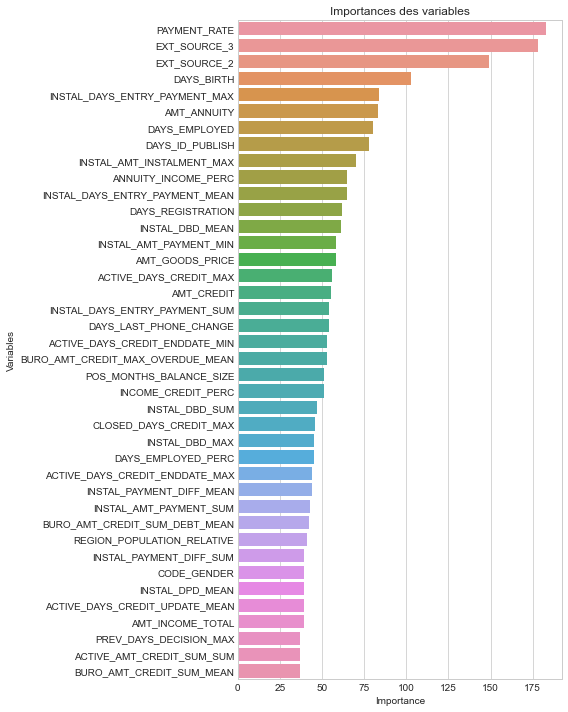

In [194]:
feature_importance_df_ = pd.DataFrame()
feature_importance_df_['Variables'] = pd.Series(X_train.columns)
feature_importance_df_['Importance'] = best_model.feature_importances_
cols = feature_importance_df_[['Variables', 'Importance']].groupby('Variables').mean().sort_values(by='Importance', ascending=False)[:40].index
best_features = feature_importance_df_.loc[feature_importance_df_.Variables.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Variables', data=best_features.sort_values(by='Importance', ascending=False))
plt.title('Importances des variables')
plt.tight_layout()

Dans la suite, nous étudierons l'importance des variables pour une prédiction en particulier.

In [195]:
# ID du client
id = 57

## SHAP
Pour interpréter le modèle, la méthode SHAP ajoute chacune des variable et calcule sa contribution marginale à la prédiction.

In [196]:
shap.initjs()

In [197]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [199]:
print('Valeur réelle :', y_test[id])
print('Valeur prédite :', best_model.predict_proba(X_test)[id, 1])

Valeur réelle : 1
Valeur prédite : 0.960198644745261


### **Force Plot** :
- Affiche la valeur en sortie du modèle pour le client.
- Affiche la *valeur de base* : valeur qui serait prédite si nous ne connaissions aucune variable concernant le client.
- Affiche l'impact de chacune des variables (les plus importantes) sur la prédiction.

In [11]:
shap.force_plot(explainer.expected_value[1], shap_values[1][id, :], X_test.iloc[id, :], link='logit')

NameError: name 'shap' is not defined

### **Summary Plot** :

Pour chacune des variables, nous identifions son impact sur le modèle (calculé sur l'ensemble des données de test).

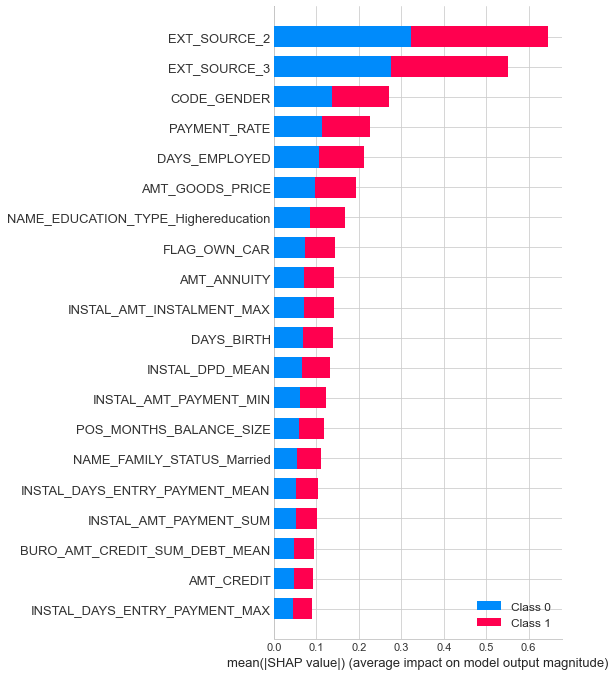

In [201]:
shap.summary_plot(shap_values, X_test)

In [19]:
import pandas as pd
df = pd.read_csv('../API/df_API_lite.csv')
print(df.shape)
df.head()

(25655, 516)


,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,249310,0.0,1.0,0.0,0.0,-0.454545,-0.663172,-0.492490,-0.656566,-0.194511,...,0.129400,0.119127,0.113668,-0.126544,0.154134,0.138133,0.216374,0.400456,0.201249,0.085714
1,185939,0.0,0.0,0.0,1.0,0.681818,-0.223037,-0.286337,-0.262626,0.338425,...,0.857738,1.033003,-0.389265,2.891982,1.255012,1.392972,0.198830,-0.503438,-0.794066,0.457143
2,399289,0.0,0.0,1.0,0.0,0.363636,-0.496805,0.016231,-0.505051,-0.044005,...,-0.459848,-0.418453,0.684634,-0.272353,-0.425498,-0.405189,-3.771930,-0.846045,0.106455,-0.400000
3,408269,0.0,0.0,0.0,0.0,0.227273,-0.665206,-0.791182,-0.707071,-0.494184,...,0.018156,-0.303932,1.580341,-0.223694,0.044705,-0.289445,-6.286550,-1.882753,-0.162441,-0.400000
4,372727,0.0,0.0,1.0,0.0,-0.363636,-0.263169,-0.696948,-0.404040,0.202337,...,0.262056,-0.427263,2.986407,-0.032267,0.985250,-0.342233,-1.532164,0.236022,0.506091,-0.600000


In [21]:
df.loc[:, df.columns != 'SK_ID_CURR'].head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0.0,1.0,0.0,0.0,-0.454545,-0.663172,-0.492490,-0.656566,-0.194511,-12934.0,...,0.129400,0.119127,0.113668,-0.126544,0.154134,0.138133,0.216374,0.400456,0.201249,0.085714
1,0.0,0.0,0.0,1.0,0.681818,-0.223037,-0.286337,-0.262626,0.338425,-18245.0,...,0.857738,1.033003,-0.389265,2.891982,1.255012,1.392972,0.198830,-0.503438,-0.794066,0.457143
2,0.0,0.0,1.0,0.0,0.363636,-0.496805,0.016231,-0.505051,-0.044005,-20110.0,...,-0.459848,-0.418453,0.684634,-0.272353,-0.425498,-0.405189,-3.771930,-0.846045,0.106455,-0.400000
3,0.0,0.0,0.0,0.0,0.227273,-0.665206,-0.791182,-0.707071,-0.494184,-13907.0,...,0.018156,-0.303932,1.580341,-0.223694,0.044705,-0.289445,-6.286550,-1.882753,-0.162441,-0.400000
4,0.0,0.0,1.0,0.0,-0.363636,-0.263169,-0.696948,-0.404040,0.202337,-17869.0,...,0.262056,-0.427263,2.986407,-0.032267,0.985250,-0.342233,-1.532164,0.236022,0.506091,-0.600000


In [27]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
knn.fit(df.loc[:, df.columns != 'SK_ID_CURR'])

def get_neighbors(id):
    return knn.kneighbors(df.iloc[id, :].reshape(1, -1), 10, return_distance=False)

In [28]:
print(get_neighbors(4))

c:\Users\charl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[ 3.72727000e+05  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00 -3.63636364e-01 -2.63168689e-01 -6.96947674e-01
 -4.04040404e-01  2.02336924e-01 -1.78690000e+04 -5.81000000e+02
 -1.50960031e+00 -1.41800000e+03  1.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.00000000e+00  2.00000000e+00  2.00000000e+00  1.20000000e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.58235735e-01  1.60027672e+00
  2.42841658e-01  1.77417071e+00  3.43655101e+00  3.75149211e-01
  1.97332762e+00  3.78413856e+00  2.37789840e-01  1.79142045e+00
  3.43477053e+00  1.97639843e+00  5.00000000e-01  0.00000000e+00
  5.00000000e-01  0.00000000e+00  5.96899225e-02  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.83286467e+00
 -4.30805107e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00 -5.28074124e-01  2.45267637e-02
  7.12643678e-01 -4.83008669e-01 -5.82737204e-01  3.18479916e-02
 -3.69252078e+00 -9.97148361e-01  0.00000000e+00 -4.75430262e-01
 -6.30316227e-01 -1.29641927e+00 -1.38358058e+00  0.00000000e+00
  0.00000000e+00  2.98684997e-01 -7.21706373e-01 -6.89539114e-01
 -7.74425174e-01  5.53456121e-01  5.75735702e-01 -4.34494332e-01
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00762560e+00 -1.67928627e+00  0.00000000e+00  1.69554066e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.26767399e-01 -7.43993622e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.69116569e-01  7.95163490e-01
  5.68736300e-01 -5.54972578e-01  1.00000000e+00  1.00000000e+00
  1.69149019e-01  1.81059283e-01  8.93753593e-03  7.04760782e-02
  1.17582276e-01  1.48424265e-01  1.00000000e+00  6.91873600e-01
  1.00000000e+00  1.00000000e+00  4.45086595e-01  1.58153755e-01
 -1.69349250e+00 -6.10770284e-01  0.00000000e+00 -3.07551546e-01
 -1.25102904e+00 -1.98589234e+00 -9.30449087e-01  0.00000000e+00
  0.00000000e+00 -9.15606019e-01 -7.79084785e-01 -9.45162221e-01
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  9.15747791e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
 -1.08333333e+00  3.52866812e-01 -7.50000000e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.64848485e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.28000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.50000000e-01  1.50000000e+00 -1.66666667e-01
 -9.59073998e-02 -6.89655172e-02 -4.21052632e-01  1.25151693e+00
 -5.30303030e-01  6.79423227e+00  5.69615457e+01 -2.25909147e-01
  9.55638008e+01  0.00000000e+00 -2.26415511e+01 -3.22577523e+00
  4.97947980e+00 -2.65578050e-02  2.62056225e-01 -4.27263405e-01
  2.98640721e+00 -3.22669697e-02  9.85249850e-01 -3.42232995e-01
 -1.53216374e+00  2.36021521e-01  5.06090578e-01 -6.00000000e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.